In [11]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir(r"C:\Users\aadya\Desktop\Intership Task\cat vs doc"))

['sampleSubmission.csv', 'test1', 'train']


In [12]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [35]:
filenames = os.listdir(r"C:\Users\aadya\Desktop\Intership Task\cat vs doc\train\train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [36]:
df.head()

filename  category
0     cat.0.jpg         0
1     cat.1.jpg         0
2    cat.10.jpg         0
3   cat.100.jpg         0
4  cat.1000.jpg         0

In [37]:
df.tail()

filename  category
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1

<Axes: >

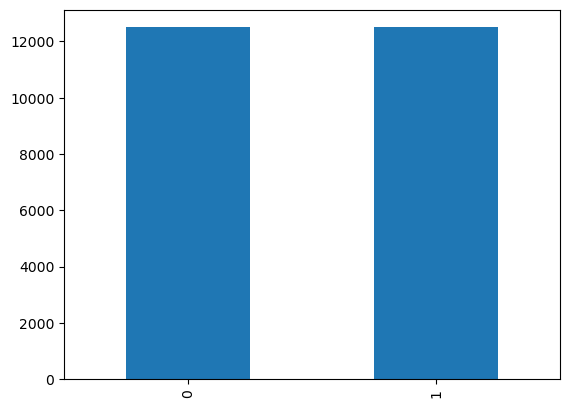

In [38]:
df['category'].value_counts().plot.bar()

In [39]:
sample = random.choice(filenames)
image = load_img(r"C:\Users\aadya\Desktop\Intership Task\cat vs doc\train\train"+sample)
plt.imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\aadya\\Desktop\\Intership Task\\cat vs doc\\train\\traincat.4064.jpg'

In [40]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)      

In [41]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [42]:
earlystop = EarlyStopping(patience=10)

In [43]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [44]:
callbacks = [earlystop, learning_rate_reduction]

In [45]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [46]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

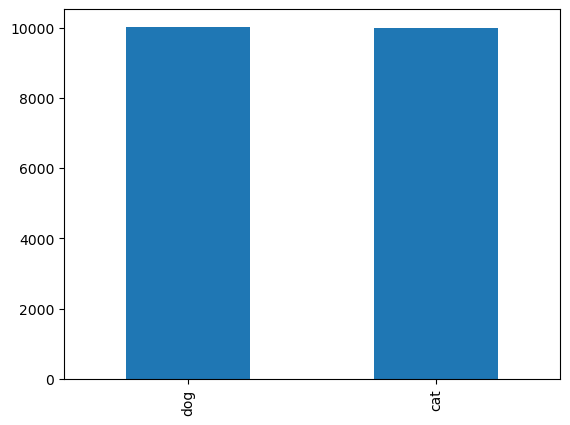

In [47]:
train_df['category'].value_counts().plot.bar()

<Axes: >

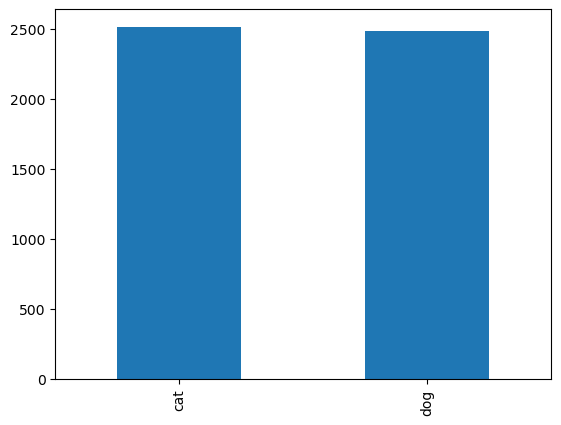

In [48]:
validate_df['category'].value_counts().plot.bar()

In [61]:
batch_size = 32
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    r"C:\Users\aadya\Desktop\Intership Task\cat vs doc\train\train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 20000 validated image filenames belonging to 2 classes.


In [63]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"C:\Users\aadya\Desktop\Intership Task\cat vs doc\train\train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [64]:

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    r"C:\Users\aadya\Desktop\Intership Task\cat vs doc\train\train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


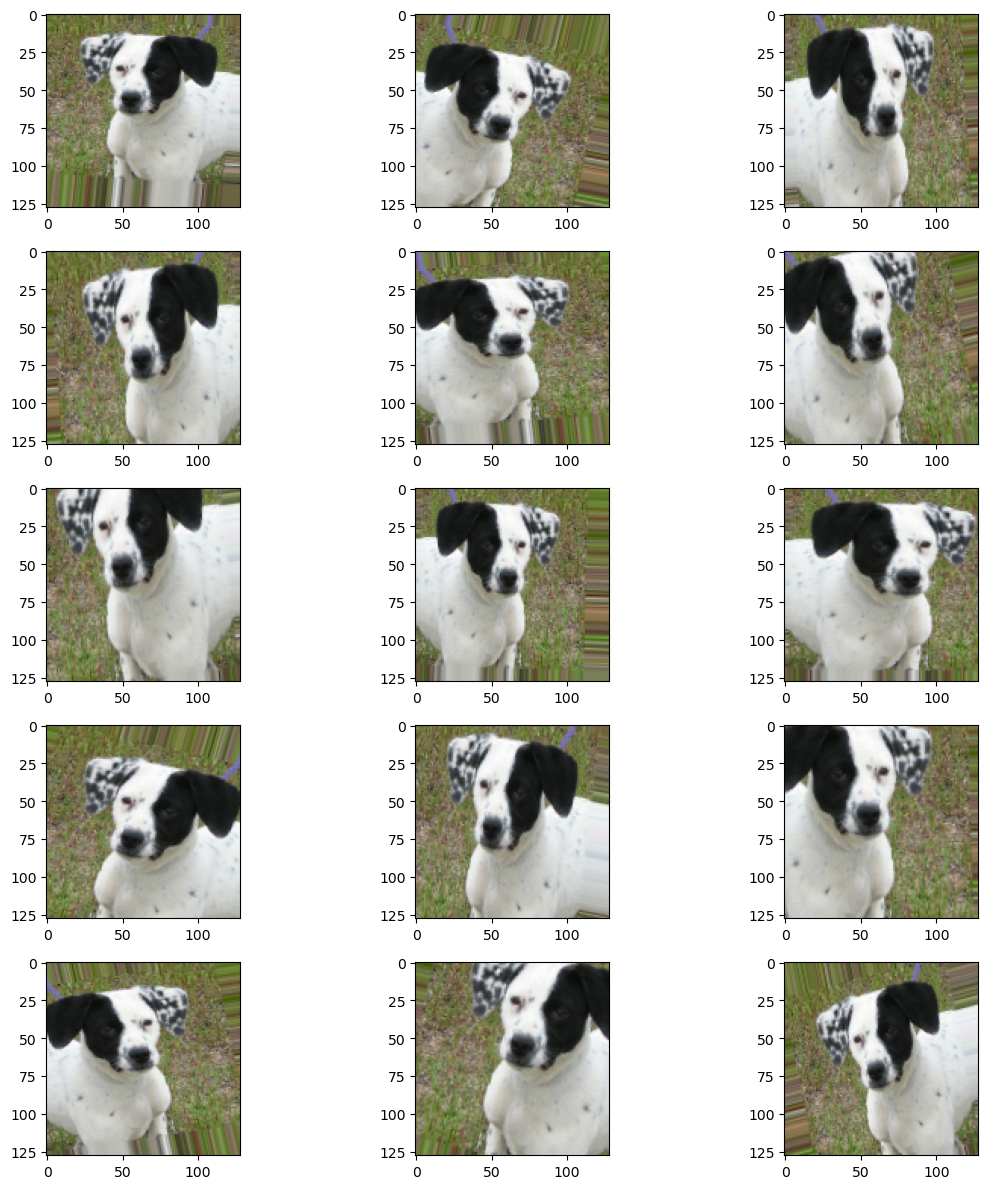

In [65]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [66]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


C:\Users\aadya\AppData\Local\Temp\ipykernel_3568\612699584.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


625/625 [==============================] - 301s 483ms/step - loss: 0.5444 - accuracy: 0.7298 - val_loss: 0.5373 - val_accuracy: 0.7466 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 316s 506ms/step - loss: 0.4759 - accuracy: 0.7771 - val_loss: 0.5774 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 300s 480ms/step - loss: 0.4389 - accuracy: 0.7978 - val_loss: 0.5286 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 301s 482ms/step - loss: 0.4049 - accuracy: 0.8143 - val_loss: 0.4626 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 298s 476ms/step - loss: 0.3871 - accuracy: 0.8239 - val_loss: 0.4629 - val_accuracy: 0.8209 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 296s 473ms/step - loss: 0.3638 - accuracy: 0.8382 - val_loss: 0.3746 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 7/50
625/625 [==============================] - 295

625/625 [==============================] - 300s 481ms/step - loss: 0.2647 - accuracy: 0.8895 - val_loss: 0.2438 - val_accuracy: 0.9034 - lr: 0.0010
Epoch 22/50
625/625 [==============================] - 298s 476ms/step - loss: 0.2662 - accuracy: 0.8899 - val_loss: 0.3802 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 23/50
625/625 [==============================] - 298s 477ms/step - loss: 0.2651 - accuracy: 0.8902 - val_loss: 0.2313 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 24/50
625/625 [==============================] - 311s 498ms/step - loss: 0.2591 - accuracy: 0.8918 - val_loss: 0.5516 - val_accuracy: 0.8085 - lr: 0.0010


In [67]:
model.save_weights("model.h5")

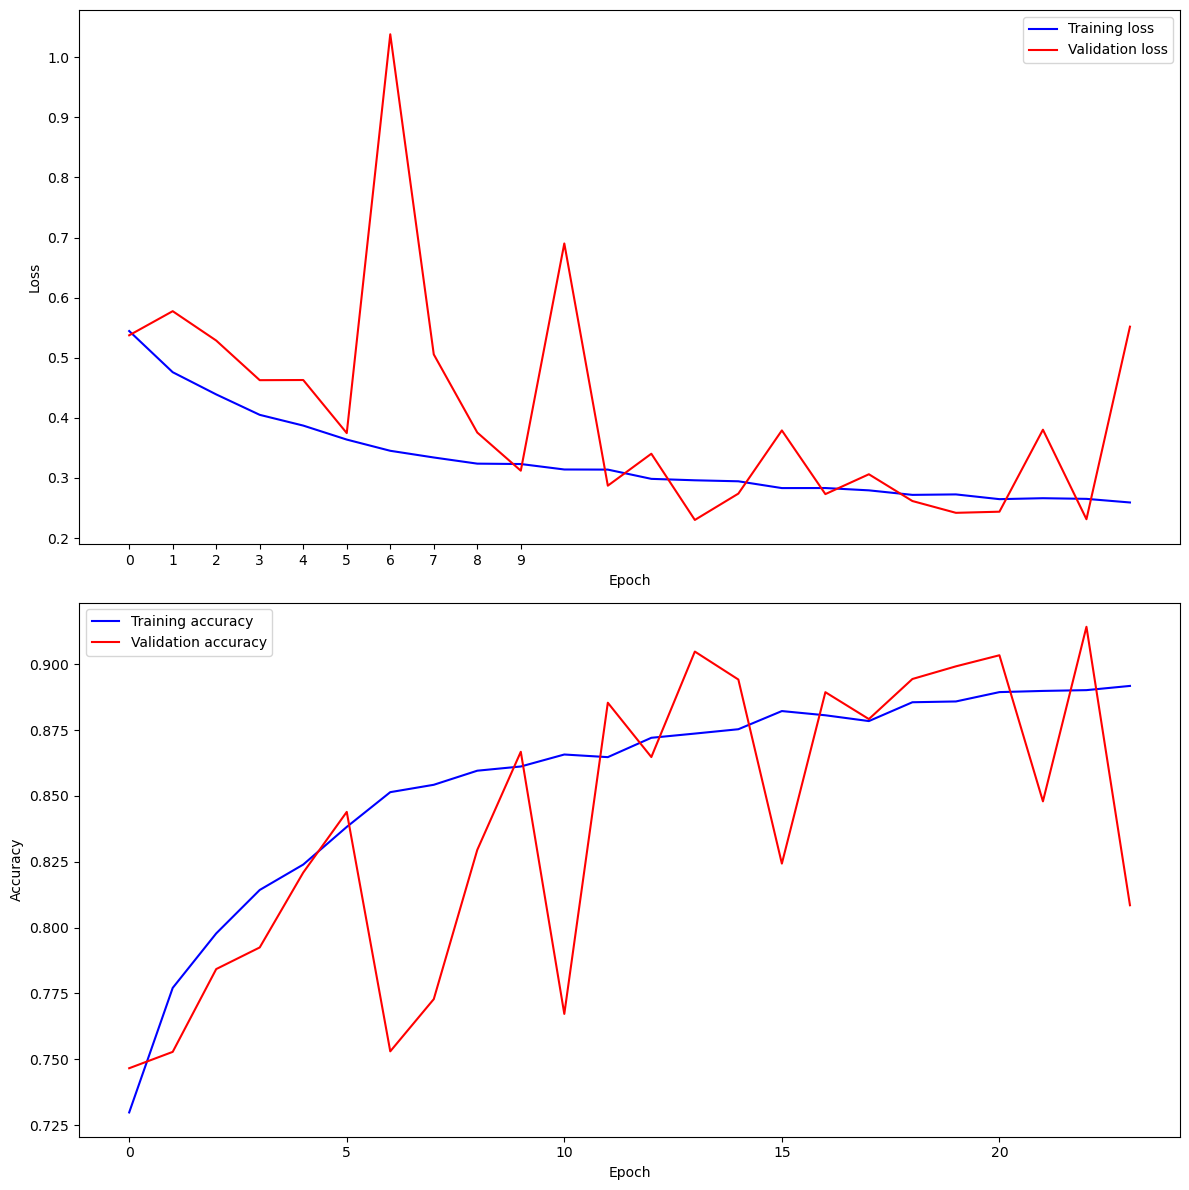

In [71]:
epochs = 10

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(0, epochs, 1))
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

if 'accuracy' in history.history:
    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()

plt.tight_layout()
plt.show()

In [72]:
test_filenames = os.listdir(r"C:\Users\aadya\Desktop\Intership Task\cat vs doc\test1\test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [73]:

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"C:\Users\aadya\Desktop\Intership Task\cat vs doc\test1\test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [74]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\aadya\AppData\Local\Temp\ipykernel_3568\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [75]:
test_df['category'] = np.argmax(predict, axis=-1)

In [76]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [77]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<Axes: >

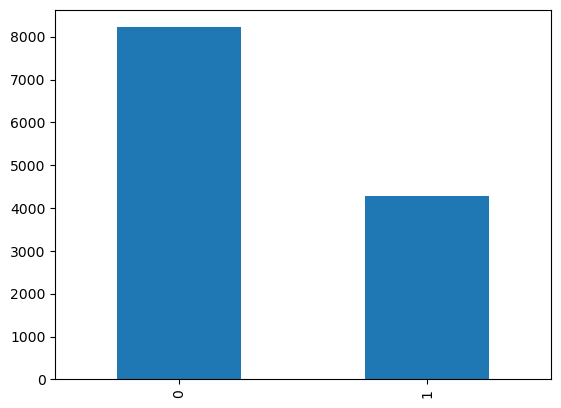

In [78]:
test_df['category'].value_counts().plot.bar()

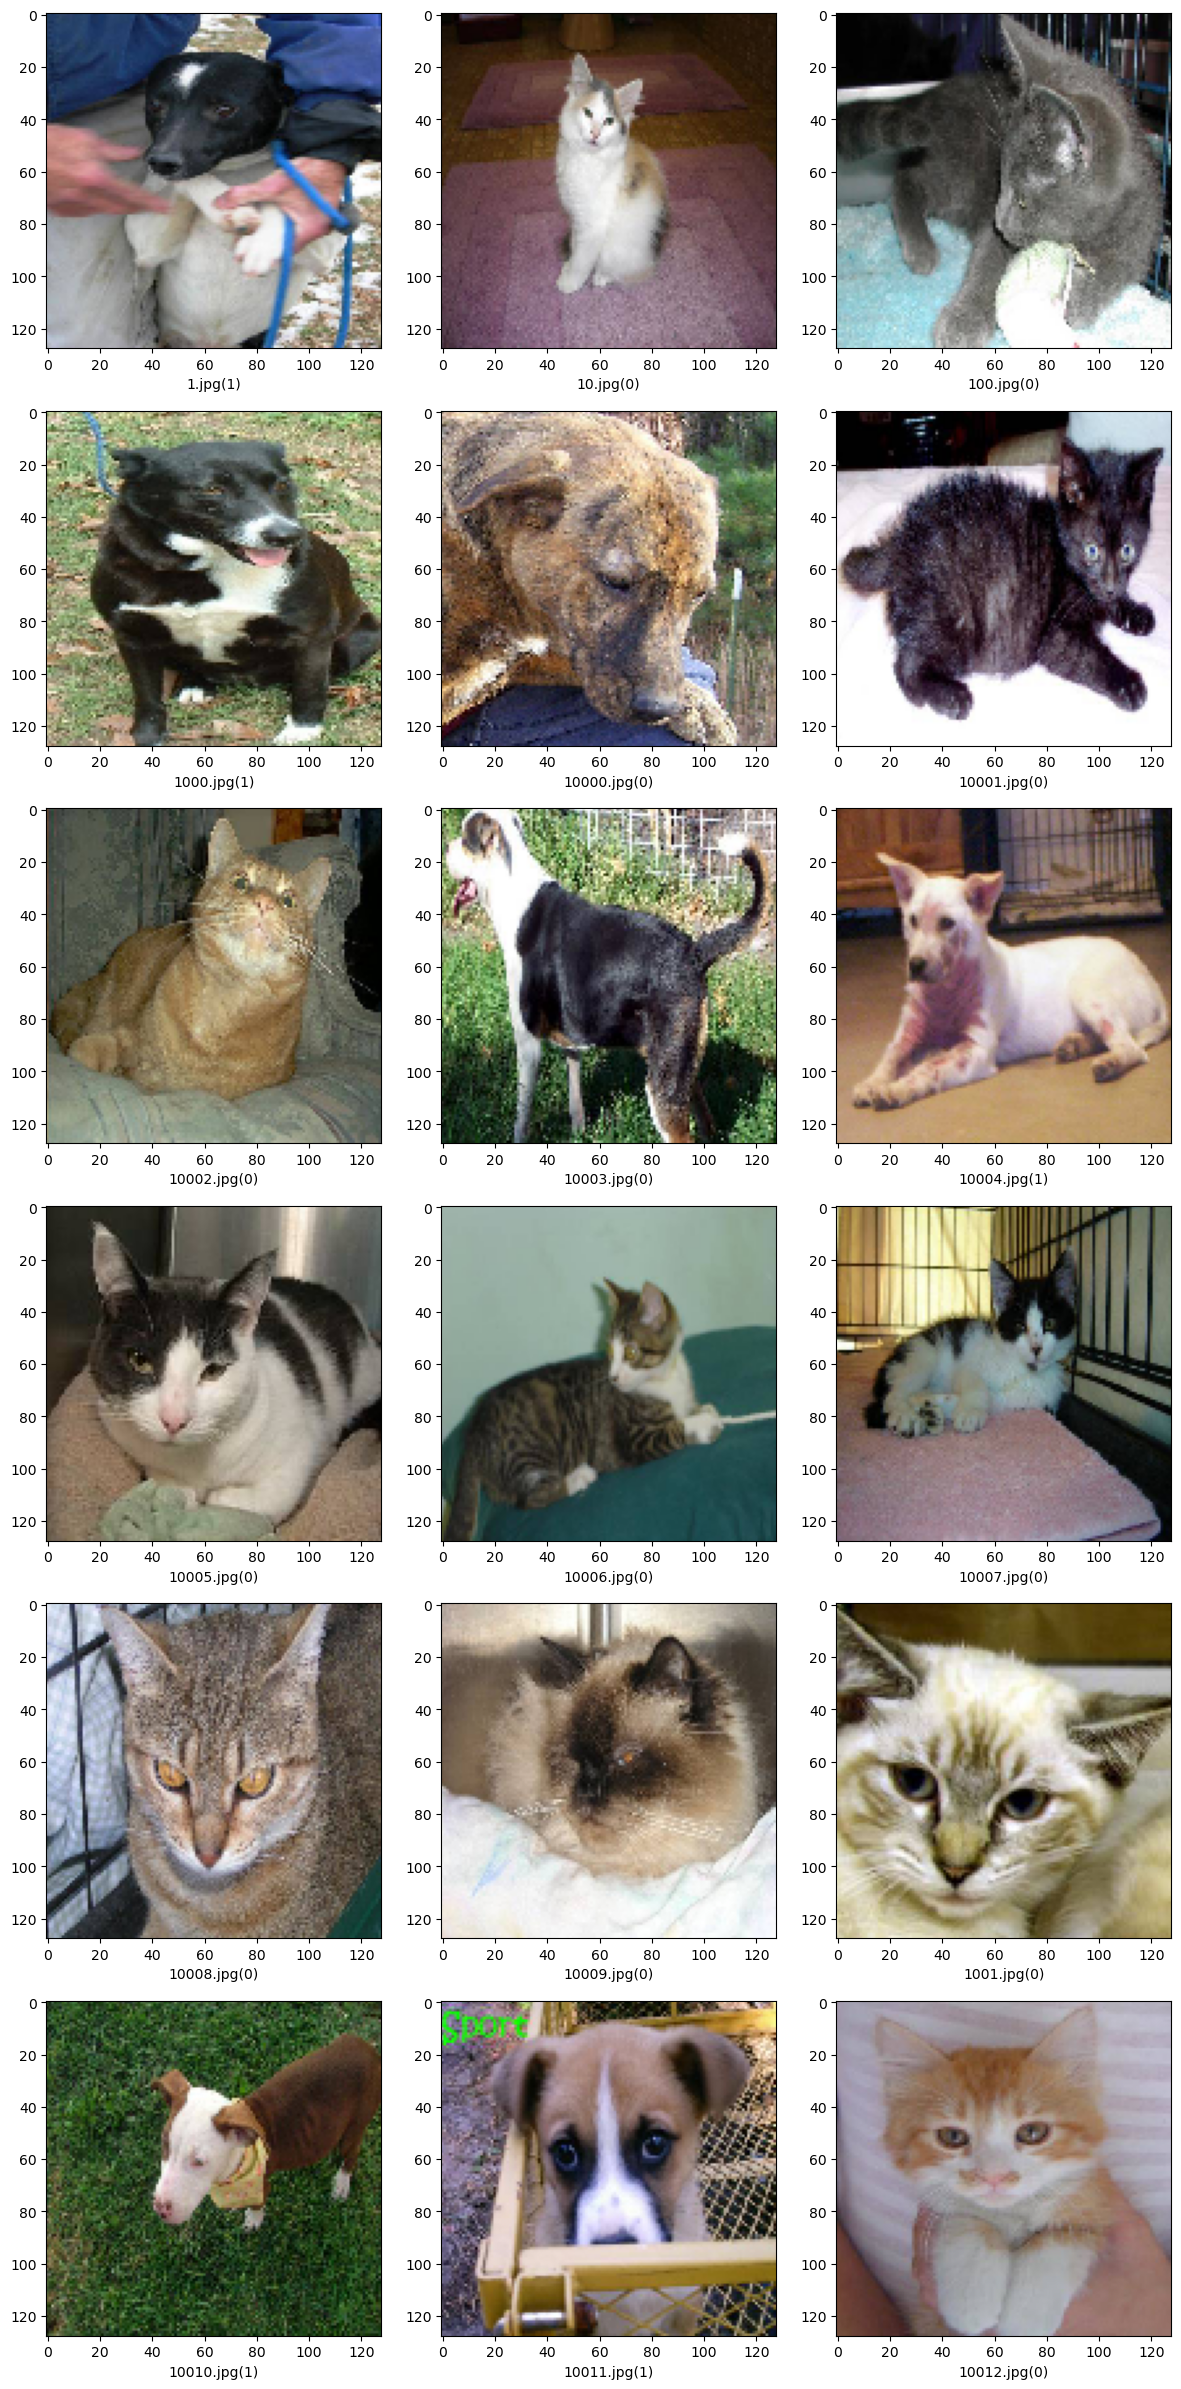

In [84]:
sample_test = test_df.head(18)

plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(r"C:\Users\aadya\Desktop\Intership Task\cat vs doc\test1\test1\\" + filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )

plt.tight_layout()
plt.show()


In [85]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)